In [5]:
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [6]:
def load_split_data(train_path="train.csv", val_path='validation.csv', test_path='test.csv'):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    return train_df, val_df, test_df

# Train model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Evaluate model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    return accuracy, report


In [16]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.sklearn
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

def plot_confusion_matrix(y_true, y_pred, model_name, dataset="Validation"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f'Confusion Matrix for {model_name} ({dataset} Set)')
    plt.show()


def train_and_evaluate():
    """Train models, track experiments with MLflow, and evaluate the best model based on AUCPR."""
    
    # Load Data
    train_df, val_df, test_df = load_split_data()

    # Vectorize Text Data
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_df['message'])
    X_val = vectorizer.transform(val_df['message'])
    X_test = vectorizer.transform(test_df['message'])
    
    y_train, y_val, y_test = train_df['label'], val_df['label'], test_df['label']

    models = {
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(probability=True),  # Enable probability for AUCPR
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    best_model = None
    best_model_name = None  # To store the name of the best model
    best_aucpr = 0

    # Set MLflow Tracking
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment("SMS_Spam_Classification")

    for name, model in models.items():
        print(f'\nTraining {name}...')
        
        with mlflow.start_run(run_name=name):
            # Train model
            model = train_model(model, X_train, y_train)

            # Predict on validation set
            y_val_probs = model.predict_proba(X_val)[:, 1]  # Get spam probability
            y_val_pred = model.predict(X_val)  # Get predicted labels
            
            # Compute AUCPR
            aucpr = average_precision_score(y_val, y_val_probs)

            # Log Parameters & Metrics in MLflow
            mlflow.log_param("model_name", name)
            mlflow.log_metric("AUCPR", aucpr)

            # Log Model
            mlflow.sklearn.log_model(model, name)

            print(f'Validation AUCPR for {name}: {aucpr:.4f}\n')

            # Plot Confusion Matrix for Validation Set
            plot_confusion_matrix(y_val, y_val_pred, name, dataset="Validation")

            # Track Best Model
            if aucpr > best_aucpr:
                best_aucpr = aucpr
                best_model = model
                best_model_name = name  # Save best model name

    # Print Best Model
    print(f"\n🔥 Best Model Selected: {best_model_name} with AUCPR: {best_aucpr:.4f} 🔥")

    # Final Test Evaluation
    print(f'\nEvaluating {best_model_name} on the test set...')
    y_test_pred = best_model.predict(X_test)  # Get predicted labels
    y_test_probs = best_model.predict_proba(X_test)[:, 1]
    test_aucpr = average_precision_score(y_test, y_test_probs)

    print(f'Test AUCPR: {test_aucpr:.4f}\n')

    # Plot Confusion Matrix for Test Set
    plot_confusion_matrix(y_test, y_test_pred, best_model_name, dataset="Test")

    # Log Best Model Performance
    with mlflow.start_run(run_name="Best_Model"):
        mlflow.log_param("best_model", best_model_name)
        mlflow.log_metric("test_AUCPR", test_aucpr)
        mlflow.sklearn.log_model(best_model, "Best_Model")

    print("✅ Experiment tracking complete! Check MLflow UI for details.")


2025/03/07 14:46:13 INFO mlflow.tracking.fluent: Experiment with name 'SMS_Spam_Classification' does not exist. Creating a new experiment.



Training Naive Bayes...


2025/03/07 14:46:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation AUCPR for Naive Bayes: 0.9597



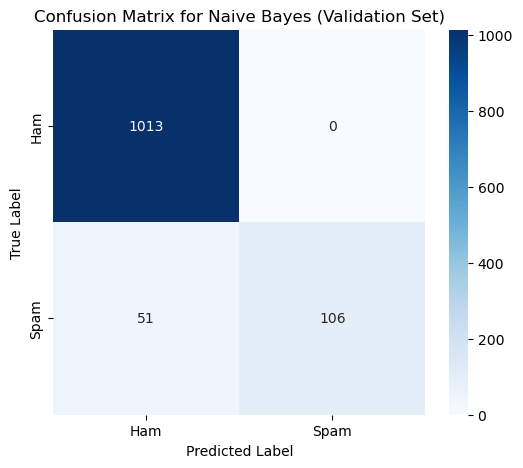

🏃 View run Naive Bayes at: http://127.0.0.1:5000/#/experiments/898734194807455091/runs/f163e92e44ad4bbca0d029d8c8e23179
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/898734194807455091

Training SVM...


2025/03/07 14:46:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation AUCPR for SVM: 0.9768



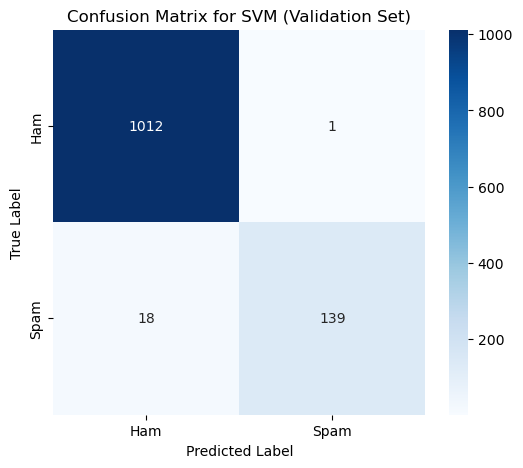

🏃 View run SVM at: http://127.0.0.1:5000/#/experiments/898734194807455091/runs/6a98e65eab364603b79f302268092078
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/898734194807455091

Training Random Forest...


2025/03/07 14:46:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation AUCPR for Random Forest: 0.9805



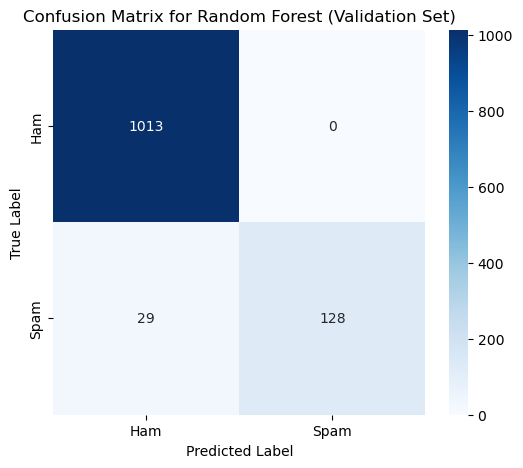

🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/898734194807455091/runs/736a6ec665b841a2bc0357e0e7a73fc6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/898734194807455091

🔥 Best Model Selected: Random Forest with AUCPR: 0.9805 🔥

Evaluating Random Forest on the test set...
Test AUCPR: 0.9723



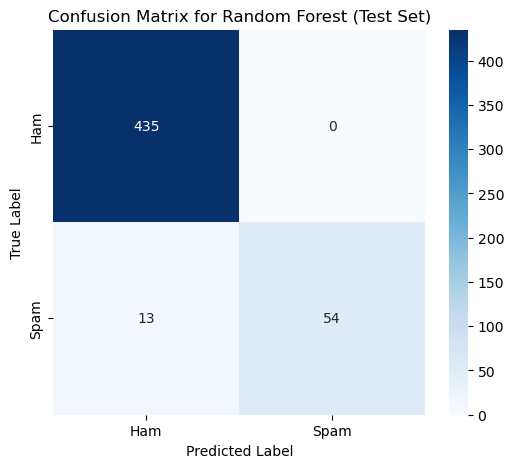

2025/03/07 14:46:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Best_Model at: http://127.0.0.1:5000/#/experiments/898734194807455091/runs/5eb53f6968854abba7bcc0f78e1cae65
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/898734194807455091
✅ Experiment tracking complete! Check MLflow UI for details.


In [17]:
train_and_evaluate()